In [1]:
import numpy as np
import pandas as pd
import vectorbt as vbt
from datetime import timedelta, datetime

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

# ------Recursion process------
# remainder_0 = investment_0 % Close
# cash_in_1 = investment_1 + remainder_0
# remainder_1 = cash_in_1 % Close
# cash_in_2 = investment_2 + remainder_1
# remainder_2 = cash_in_2 % Close

# Select target stock, setup investment start date & end date
start = '2018-09-01'
end = datetime.now()
price_data = vbt.YFData.download('3443.TW', start=start, end=end).get('Close')
price_data = pd.DataFrame(price_data, columns=['Close'])

# Define DCA parameters
initial_investment = 3300  # Initial investment amount
investment_interval = 'M'  # Investment interval (e.g., '1M' for 1 month)
monthly_investment = 3300
fees = 0.001425

# Create a signal DataFrame with investment amounts

# Index.min() method select the earliest date of the period
investment_dates = price_data.loc[price_data.groupby(price_data.index.to_period(investment_interval)).apply(lambda df: df.index.min())].index
initial_investment = np.array([initial_investment])
investment_amounts = np.concatenate((initial_investment,np.repeat(monthly_investment, len(investment_dates)-1)))
signal_data = pd.DataFrame({'investment': investment_amounts}, index=investment_dates)

# Perform DCA simulation
signal_data['Close'] = price_data['Close']

signal_data.loc[signal_data.index.min(),'cash_remainder'] = (
                                                            (signal_data.loc[signal_data.index.min(),'investment'] % signal_data.loc[signal_data.index.min(),'Close'])
                                                             -((signal_data.loc[signal_data.index.min(),'investment'] // signal_data.loc[signal_data.index.min(),'Close'])
                                                             * signal_data.loc[signal_data.index.min(),'Close'] * fees)
                                                            )

signal_data.loc[signal_data.index.min(),'cash_in'] = signal_data.loc[signal_data.index.min(),'investment']

for i in range(1, len(signal_data)):
    signal_data.iloc[i, 3] = signal_data.iloc[i,0] + signal_data.iloc[i-1, 2]
    signal_data.iloc[i, 2] = signal_data.iloc[i,3] % signal_data.iloc[i, 1]

signal_data['shares_bought'] = signal_data['cash_in'] // signal_data['Close']
signal_data['fees'] = (signal_data['shares_bought'] * signal_data['Close'])*fees
signal_data['shares_bought_cost'] = signal_data['shares_bought'] * signal_data['Close'] + (signal_data['shares_bought'] * signal_data['Close'])*fees
signal_data['total_shares'] = signal_data['shares_bought'].cumsum()
signal_data['portfolio_value'] = signal_data['total_shares'] * signal_data['Close'] + signal_data['cash_remainder']
signal_data['total_cost'] = signal_data['shares_bought_cost'].cumsum()
signal_data['Avg_cost_per_share'] = signal_data['shares_bought_cost'].cumsum() / signal_data['total_shares']
signal_data['revenue(%)'] = signal_data['portfolio_value']/signal_data['total_cost']-1

# Print results
signal_data

/Users/jin/anaconda3/lib/python3.10/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)
/var/folders/yg/lhvxxbpd4c3b9pq8_13vmq3r0000gn/T/ipykernel_4579/1242160019.py:33: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  investment_dates = price_data.loc[price_data.groupby(price_data.index.to_period(investment_interval)).apply(lambda df: df.index.min())].index


,investment,Close,cash_remainder,cash_in,shares_bought,fees,shares_bought_cost,total_shares,portfolio_value,total_cost,Avg_cost_per_share,revenue(%)
Date,,,,,,,,,,,,
2018-09-02 16:00:00+00:00,3300,276.934021,249.384828,3300.000000,11.0,4.340941,3050.615172,11.0,3.295659e+03,3050.615172,277.328652,0.080326
2018-10-01 16:00:00+00:00,3300,248.317505,72.939760,3549.384828,14.0,4.953934,3481.399003,25.0,6.280877e+03,6532.014174,261.280567,-0.038447
2018-11-01 16:00:00+00:00,3300,204.469620,101.425844,3372.939760,16.0,4.661907,3276.175823,41.0,8.484680e+03,9808.189998,239.224146,-0.134939
2018-12-02 16:00:00+00:00,3300,199.392487,11.753572,3401.425844,17.0,4.830283,3394.502555,58.0,1.157652e+04,13202.692552,227.632630,-0.123170
2019-01-01 16:00:00+00:00,3300,187.853577,118.242769,3311.753572,17.0,4.550753,3198.061556,75.0,1.420726e+04,16400.754108,218.676721,-0.133743
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01 16:00:00+00:00,3300,1085.013062,412.954088,3667.993272,3.0,4.638431,3259.677615,600.0,6.514208e+05,187950.152826,313.250255,2.465923
2023-06-01 16:00:00+00:00,3300,1425.000000,862.954088,3712.954088,2.0,4.061250,2854.061250,602.0,8.587130e+05,190804.214076,316.950522,3.500493
2023-07-02 16:00:00+00:00,3300,1670.000000,822.954088,4162.954088,2.0,4.759500,3344.759500,604.0,1.009503e+06,194148.973576,321.438698,4.199631


In [2]:
# test periodicly groupby method
# investment_interval = 'W'  # Investment interval (e.g., '1M' for 1 month)
# price_data.groupby(price_data.index.to_period(investment_interval)).apply(lambda df: df.index.min())

In [3]:
year = (signal_data.index[-1]-signal_data.index[0]).total_seconds() / 60 / 60 / 24 / 365
ROI = signal_data['revenue(%)'].iloc[-1]
IRR = ((ROI+1)**(1/year))-1
print(
'Period(year): {} (yrs)\n\
Benchmark return: {}%\n\
ROI: {}%\n\
IRR: {}%\n\
Total cost: ${}\n\
Total value: ${}\n\
Cumulated cap gains: ${}'
    .format(
        round(year,2),
        round((signal_data['Close'].iloc[-1] / signal_data['Close'].iloc[0]-1)*100, 2),
        round(ROI*100,2),
        round(IRR*100,2),
        round(signal_data['total_cost'].iloc[len(signal_data)-1],2),
        round(signal_data['portfolio_value'].iloc[-1]),
        round(signal_data['portfolio_value'].iloc[len(signal_data)-1]-signal_data['total_cost'].iloc[len(signal_data)-1],2)
            )
    )

Period(year): 5.01 (yrs)
Benchmark return: 421.78%
ROI: 337.29%
IRR: 34.28%
Total cost: $201304.16
Total value: $880283
Cumulated cap gains: $678978.8


### Cycle type

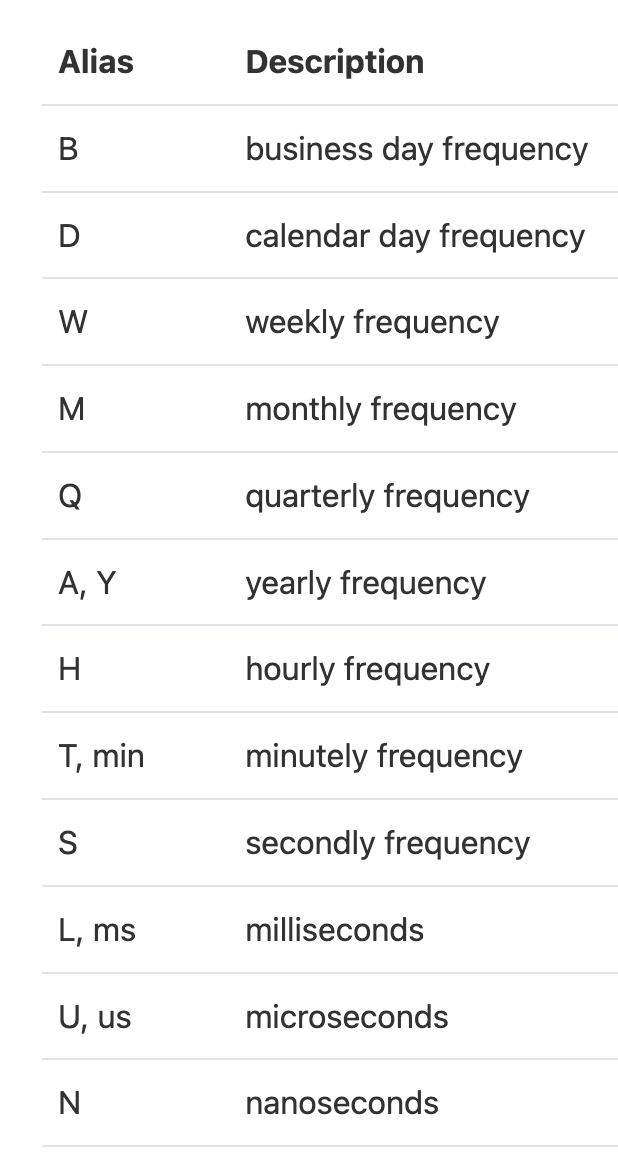